In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as ss

In [2]:
from nltk.corpus import stopwords
import regex as re

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB
from sklearn.svm import SVC
#Forests

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning);

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score

In [5]:
from random import choices

In [6]:
df = pd.read_csv('../data/cleaned_02_ii.csv')
print(df.shape)
df.head()

(39565, 60)


,platform,text,hate_speech_score,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,...,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability,hate_rank,capital_sentance,cleaned_text,wc_cleaned_text
0,0,White people are trash.,0.46,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,white peopl are trash,4
1,0,"You've caught the big gay, it's known to be ai...",0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,you ve caught the big gay it s known to be air...,14
2,0,"I'm not saying you said that, I'm just saying ...",-1.29,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,i m not say you said that i m just say that if...,75
3,0,Donald Trump. Yeet myself off a building onto ...,-0.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,donald trump yeet myself off a build onto a ga...,20
4,0,Fabrice Fabrice is ostensibly black or black/l...,-2.84,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,fabric fabric is ostens black or black latino ...,19


In [7]:
# h wait, let me copy over the fllowing:
# hate_speech_score - continuous hate speech measure, where higher = more hateful and lower = less hateful. 
# > 0.5 is approximately hate speech, < -1 is counter or supportive speech, and -1 to +0.5 is neutral or ambiguous.

# ...Misread this - ambiguous also goes below...

lower_limit, upper_limit = .5, 2
df['hate_rank'] = [2 if i > upper_limit
                  else 1 if i > lower_limit else 0
                  for i in df['hate_speech_score']]
df['hate_rank'].value_counts(normalize=True)

hate_rank
0    0.738304
1    0.208973
2    0.052723
Name: proportion, dtype: float64

# Round I of modeling!

Reminder again that our target is somewhat ambiguous, tweaks to be adjusted to the 'cleaned text' among other things before the anticipated 'fun' of adding in other factors such as platform and target.

In [8]:
X = df['cleaned_text']
y = df['hate_rank']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25, #Given the size we'll start with this, a bit larger than what I'd usually do
                                                    random_state = 26, #I like this number
                                                    stratify=y) #Particularly important in this case with 3 targets

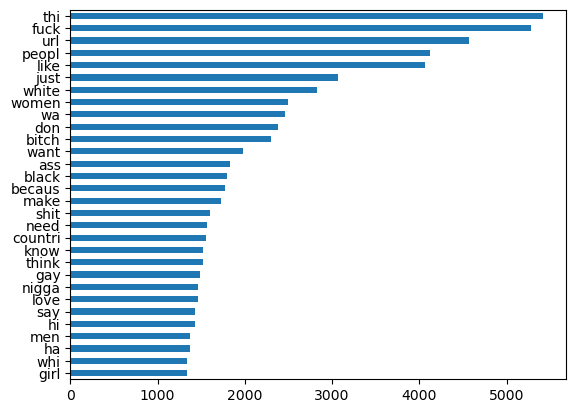

In [22]:
#For kicks, to get a bit of a taste of the upcoming data. 
cvec_ex = CountVectorizer(stop_words='english')
X_train_cvec_ex = cvec_ex.fit_transform(X_train)
X_train_ex = pd.DataFrame(X_train_cvec_ex.todense(),
                          columns=cvec_ex.get_feature_names_out())

X_train_ex.sum().sort_values().tail(30).plot(kind="barh");

Unsurprising, the 'f' word is high up there being the second mst common (only behind 'this'). Likely its presence, along with any other similar word, is more indicative of hate speech.

Other interesting words (tokens) include: just, b****, a**, white, black, woman, countri, n****, gay, men, and girl. Of particular interst to me is 'just'. Albeit it is a stopword, however

In [16]:
# stopwords.words().index('just')

3083

In [18]:
X_train_ex.shape[1]#Ww, quite a lot of words...

28445

In [ ]:
# pipe = Pipeline([
#     ('cvec', CountVectorizer(lowercase=False))
#     ,('lr', LogisticRegression(max_iter=2500, multi_class='multinomial'))
# ])

# pipe_params = {'cvec__min_df' : [.05, .00]
#                ,'cvec__max_df' : [.95, 1.00]
#                ,'cvec__ngram_range' : [(1, 1)]
#                ,'cvec__max_features' : [2000, 5000]
#                ,'cvec__stop_words' : ['english', None]
#               }

# gs = GridSearchCV(pipe,
#                   param_grid=pipe_params,
#                   cv=5)
# gs.fit(X_train, y_train)

# print(gs.score(X_train, y_train), gs.score(X_test, y_test))
# print(gs.best_score_)
# print(gs.best_params_)

# #Output:
# 0.7661510464058234 0.7093610998786899
# 0.7039399584704426
# {'cvec__max_df': 0.95, 'cvec__max_features': 2000, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None}

Above is a copy of the first iteration I ran, and will serve as a general template describing my thought process for the rest of this project:

Well, we got a nice bit of overfitting and overall not the greatest accuracy. Recall how we're
dealng with multi-class classification and would need to properly address the metrics - as now sensitivity seems a bit more abstruse.

Regardless, I'll keep the metrics as overall accuracy for now, as I want to do a lot better than a mere 70%.

Anyways, regarding going forward with hyper-parameters: Notice the selection of specific feature and explore that trend more. Ex. we chose .95 for max df when we had two options: .95 and 1.00. Likely let us explor if that .95 preference is even lower (such as next trying maybe .925) or a bit higher (such as .975) yet not as big as the original alternative of 1.00.

Only other parameter I'll call attention to is rejection of using English stopwords. Among other theories, perhaps related to the trend we noticed of more positive posts often being longer in length.

In [56]:
# trial_model = gs.best_estimator_
# trial_model.fit(X_train,y_train)
# print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))

# preds = gs.predict(X_test)
# preds_prob = gs.predict_proba(X_test)
# hyper_pred_comparer = pd.DataFrame({
#     'cleaned_text':X_test
#     ,'actual':y_test
#     ,'pred':preds
#     ,'p_0':preds_prob[:,0]
#     ,'p_1':preds_prob[:,1]
#     ,'p_2':preds_prob[:,2]
# })

0.7661510464058234 0.7093610998786899


In [57]:
# hyper_misses = hyper_pred_comparer[hyper_pred_comparer['actual']!=hyper_pred_comparer['pred']]
# i = -1

In [59]:
# i += 1
# print(i)
# print(hyper_misses.iloc[i, 1:3])
# print(hyper_misses.iloc[i, 3:6])
# hyper_misses.iloc[i, 0]

1
actual    0
pred      2
Name: 37719, dtype: object
p_0    0.006897
p_1    0.490072
p_2    0.503031
Name: 37719, dtype: object


'non white american pleas relax and don t worri about what crazi trump and hi mental sick support are say becaus thi countri is your and will be onli your soon these ignor pig will disappear soon if you want them to go you are go too'

In [60]:
# print(1)
# print(hyper_misses.iloc[1, 1:3])
# print(hyper_misses.iloc[i, 3:6])
# hyper_misses.iloc[1, 0]
# We'll look at this example (current per the - our model thought it was a 2:

#Yeah, I'm not surprised when it makes references to say many groups AND in a somewhat edgy way.
#Ie 'disappear' 'soon' 'crazi' 'mental/sick',etc.

1
actual    0
pred      2
Name: 37719, dtype: object
p_0    0.006897
p_1    0.490072
p_2    0.503031
Name: 37719, dtype: object


'non white american pleas relax and don t worri about what crazi trump and hi mental sick support are say becaus thi countri is your and will be onli your soon these ignor pig will disappear soon if you want them to go you are go too'

In [66]:
#All right, we got our basic methodology done. It's tuning time!!!!!!
#Think I'm excited?

pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False))
    ,('lr', LogisticRegression(max_iter=2500, multi_class='multinomial'))
])

pipe_params = {'cvec__min_df' : [.00]
               ,'cvec__max_df' : [.95]
               ,'cvec__ngram_range' : [(1, 1)]
               ,'cvec__max_features' : [1175, 1225, 1200]
               ,'cvec__stop_words' : [None]
              }
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5)
gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

0.7487952010245004 0.7071370804690659
0.7110505535617999
{'cvec__max_df': 0.95, 'cvec__max_features': 1200, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None}


In [67]:
#Hmm, it looks like this is the best we're going to get... a mere 70%... For now we'll take it.
#Note, that even with the cvec we can hopefully improve accuracy via the addition of the other featues
#such as word count, type of discrimination, etc.

In [72]:
#Continuing with Tiffany:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False))
    ,('lr', LogisticRegression(max_iter=3000, multi_class='multinomial'))
])
pipe_params = {'tvec__min_df' : [.0]
               ,'tvec__max_df' : [.95]
               ,'tvec__ngram_range' : [(1,1)]
               ,'tvec__max_features' : [2100, 2150, 2125]
               ,'tvec__stop_words' : [None]
               }
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5)

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

0.7571529673440501 0.7175495349777598
0.7184985244882702
{'tvec__max_df': 0.95, 'tvec__max_features': 2125, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


In [ ]:
#Gah, honestly also lackluster. A bit better albit, now being over 71%. #I'll still continue a bt
#more in this brutish approach.

In [76]:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('mnb', MultinomialNB())
])
pipe_params = {'cvec__min_df' : [.0]
               ,'cvec__max_df' : [.95]
               ,'cvec__ngram_range' : [(1, 1)]
               ,'cvec__max_features' : [4500, 4600, 4400]
               ,'cvec__stop_words' : ['english']
               ,'mnb__alpha': [1.0]
              }
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5)

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

0.7473123715161931 0.7098665588354226
0.7110843655384744
{'cvec__max_df': 0.95, 'cvec__max_features': 4500, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'mnb__alpha': 1.0}


In [ ]:
#Might as well try also with Tiffany, especially when I'm just grasping for at least an itial
#guess model to be above80%...

In [80]:
#TBD if we'll do pipes for both cvec and Tiffany, but we have to at least try the others:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('mnb', MultinomialNB())
])
pipe_params = {'tvec__min_df' : [.0]
               ,'tvec__max_df' : [.95]
               ,'tvec__ngram_range' : [(1,1)]
               ,'tvec__max_features' : [4500, 4400, 4600]
               ,'tvec__stop_words' : ['english', None]
               ,'mnb__alpha': [.98]
              }
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5)

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

0.7474134735281233 0.7213910230489284
0.7207563740317886
{'mnb__alpha': 0.98, 'tvec__max_df': 0.95, 'tvec__max_features': 4400, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


In [88]:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('gnb', GaussianNB())
])
pipe_params = {'cvec__min_df' : [.05]
               ,'cvec__max_df' : [.95]
               ,'cvec__ngram_range' : [(1, 1)]
               ,'cvec__max_features' : [1750, 1775, 1725]
               ,'cvec__stop_words' : ['english']
              }
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5)

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)
#Oh wow, this one did terrible... did I forget a paramter to tune?!?!Seemngly not...

0.5166986823037778 0.5109179134654266
0.5184172712530903
{'cvec__max_df': 0.95, 'cvec__max_features': 1750, 'cvec__min_df': 0.05, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english'}


In [10]:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('conb', ComplementNB())
])
pipe_params = {'cvec__min_df' : [.0]
               ,'cvec__max_df' : [.95]
               ,'cvec__ngram_range' : [(1, 1)]
               ,'cvec__max_features' : [4400, 4350, 4450]
               ,'cvec__stop_words' : [None]
               ,'conb__alpha': [1.0]
              }
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5)

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

0.7402015300104472 0.715729882733522
0.7165437560994585
{'conb__alpha': 1.0, 'cvec__max_df': 0.95, 'cvec__max_features': 4400, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None}


In [ ]:
#Reminder for the the others... we have to do them this time...

In [12]:
##Also didn't get this one either...
# pipe = Pipeline([
#     ('cvec', CountVectorizer(lowercase=False))
#     ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
#     ,('svc', SVC())
# ])
# pipe_params = {'cvec__min_df' : [.0]
#                ,'cvec__max_df' : [1.0]
#                ,'cvec__ngram_range' : [(1,1), (1,2)]
#                ,'cvec__max_features' : [2000, 4000]
#                ,'cvec__stop_words' : ['english', None]
#                ,'svc__kernel': ['linear']
#                ,'svc__C': [.95, .1]
#               }
# gs = GridSearchCV(pipe
#                   ,param_grid=pipe_params
#                   ,cv=5)
# gs.fit(X_train, y_train)

# print(gs.score(X_train, y_train), gs.score(X_test, y_test))
# print(gs.best_score_)
# print(gs.best_params_)

In [13]:
# #Won't even bother...
# pipe = Pipeline([
#     ('tvec', TfidfVectorizer(lowercase=False))
#     ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
#     ,('svc', SVC())
# ])
# pipe_params = {'tvec__min_df' : [.0]
#                ,'tvec__max_df' : [1.0]
#                ,'tvec__ngram_range' : [(1,2), (1,1)]
#                ,'tvec__max_features' : [2000, 4000]
#                ,'tvec__stop_words' : ['english']
#                ,'svc__kernel': ['linear']
#                ,'svc__C': [.95]
#               }
# gs = GridSearchCV(pipe
#                   ,param_grid=pipe_params
#                   ,cv=5)
# gs.fit(X_train, y_train)

# print(gs.score(X_train, y_train), gs.score(X_test, y_test))
# print(gs.best_score_)
# print(gs.best_params_)

## Re-evaluation

So, this approach cleearly isn't working with bottom line getting accuracies in the mere 70s. Sure, perhaps we should
redefine the borderline of hateful speach, but still...

I'll do at least one redefine before trying something else...

Recall from camp we had a few approaches with underrepresented classes. The fourth was something we'll explore momentarily.

In [15]:
df['hate_speech_score'].describe()

count    39565.000000
mean        -0.943911
std          2.073087
min         -8.340000
25%         -2.330000
50%         -0.700000
75%          0.570000
max          6.300000
Name: hate_speech_score, dtype: float64

In [19]:
df['hate_speech_score'].quantile(.95) #Eh, we'll keep it as is... 

#So, before we go again, I want to run again the 'baseline' logistic regression with a few changes:

2.04

In [47]:
# #Wait, will this even work with a sparse matrix?.... Let me try with weights first...
# ros = RandomOverSampler(random_state=26)
# X_ros, y_ros = ros.fit_resample(X, y)
# X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X
#                                                     ,y
#                                                     ,test_size = 0.25
#                                                     ,random_state = 26
#                                                     ,stratify=y_ros)

In [50]:
X.shape, y.shape

((39565,), (39565,))

In [18]:
# smote = SMOTE(random_state=26)
# X_smote, y_smote = smote.fit_resample(X, y)
# X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X
#                                                     ,y
#                                                     ,test_size = 0.25
#                                                     ,random_state = 26
#                                                     ,stratify=y_smote)

In [69]:
# pipe = Pipeline([
#     ('tvec', TfidfVectorizer(lowercase=False))
#     ,('lr', LogisticRegression(max_iter=3000, multi_class='multinomial'))
# ])
# pipe_params = {'tvec__min_df' : [.0]
#                ,'tvec__max_df' : [.95]
#                ,'tvec__ngram_range' : [(1,1)]
#                ,'tvec__max_features' : [2125]
#                ,'tvec__stop_words' : [None]
#                }
# scorer = make_scorer(recall_score, average = None) #Syntax essentially from Gunes of StackExchange
# gs = GridSearchCV(pipe
#                   ,param_grid=pipe_params
#                   ,cv=5
#                  ,scoring=scorer)

# gs.fit(X_train, y_train)

# print(gs.score(X_train, y_train), gs.score(X_test, y_test))
# print(gs.best_score_)
# print(gs.best_params_)

In [96]:
# def class_recall(class_location):
#     score = recall_score(y_true, y_pred, average = None)
#     return score[class_location]

In [79]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False))
    ,('lr', LogisticRegression(max_iter=3000, multi_class='multinomial', class_weight={0:1,1:1.25,2:4}))
])
pipe_params = {'tvec__min_df' : [.0]
               ,'tvec__max_df' : [.95]
               ,'tvec__ngram_range' : [(1,1)]
               ,'tvec__max_features' : [2125]
               ,'tvec__stop_words' : [None]
               }
scorer = make_scorer(recall_score, average = 'weighted')#Syntax essentially from Gunes of StackExchange
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5
                  ,scoring=scorer
                 )

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

0.7942237050517306 0.7551556813586737
0.7548275796468256
{'tvec__max_df': 0.95, 'tvec__max_features': 2125, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


In [80]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

0.7942237050517306 0.7551556813586737


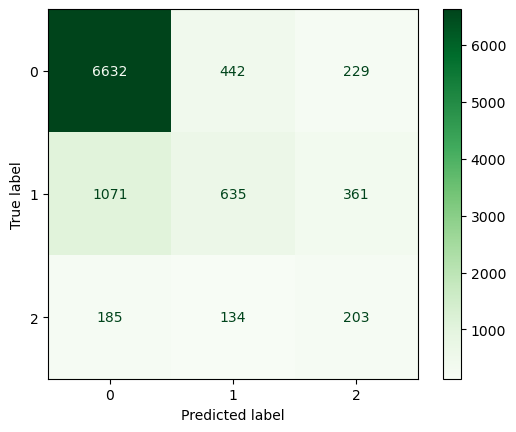

In [81]:
ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [13]:
confusion_matrix(y_test, preds)[2]

array([185, 134, 203], dtype=int64)

In [ ]:
#Hmm, let's finally get the scoring down. We're most interested in category 2; however, per revisioning the problm statement
#likely a focus on one is enough. So, this would basically be correctly identifying the negatives of 0, is tn/tn+fp is specificity
    #Ie specificity of 2s.
#Alt, go back to focusing on the most toxic 2s: tp/tp+fn sensitivity of 2s.

In [83]:
#Hmm, so after the ponderings and wanderings let us go back to our original dataframe, resample 1s and 2s, then run everything anew
df['hate_rank'].value_counts()

hate_rank
0    29211
1     8268
2     2086
Name: count, dtype: int64

In [87]:
(df.shape[0]//3000)+1 #Somewhat arbitrary number, but in short I want to: 
#1) Limit the 0 category
#2) Resample the 1 and 2 category
#14k per group was chosen to be 'as big as the original' yet still being small enough to practically work with.
    #I might change this later, as now group 2 is sooo overused. I'd be comfortable off hand with 6kish, with each post
    #likly being used 3 times each, but an on-average of 7 seems excesive... And, for whatever it matters: The other
    #big project we did with Reddit titles had 1.5kish per group...
#For consistency's sake, I will also sample 0 with replacement.

#Also, I don't think I'll bother to worry aobut original comment id. But we'll see.

14

In [8]:
# df_0 = df[df['hate_rank']==0].sample(14_000, replace=True, random_state=26)
# df_0.head()

In [9]:
# df_1 = df[df['hate_rank']==1].sample(14_000, replace=True, random_state=26) #Eh, just three so I won't bother making a for loop
# df_1.head()

In [10]:
# df_2 = df[df['hate_rank']==2].sample(14_000, replace=True, random_state=26)
# df_2.head()

In [11]:
# data = pd.concat([df_0, df_1, df_2])
# print(data.shape)
# data['hate_rank'].value_counts(normalize=True) #All right. Now let's do this.

In [102]:
#Oh wait, I just realized that likly many of the "test" results are being also used in train... hmm, yeah we need
#to do the split afterwards. Hmm, with a stratified split we'd get like .05 to be 2...
10_000/20

500.0

## The revival

A note I'd like to make before contiuing: A very practical application and need I see for this project is the assumption that a user will post multiple messages. So, even if ONE message is not caught, when you consider more and more...

In a way, that assumption arguably helps the cause to sampe with replacement, as likly hate messages would be spammed multiple times...

In [227]:
X = df['cleaned_text']
y = df['hate_rank']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 3785, #To have a clean 200 2s in the test 3785 pref
                                                    random_state = 26, #I like this number
                                                    stratify=y) #Particularly important in this case with 3 targets

# Hmm, as it stands right now y_test has mostly 0s... eh, I think htat's fine as it's like new data. So, cvs might be a little
# scruff now with seeing thet sam thing,b ut eh, better htan nothing.... And, likely such is the inhernt issue of
# using such methodologies...

In [228]:
len(y_test[y_test==2])

200

In [229]:
data = pd.DataFrame(X_train)
data['hate_rank'] = y_train
data.head()

,cleaned_text,hate_rank
33114,yea those lino do need to be turn straight bec...,1
36787,the world is come un kill billion of peopl nw ...,0
4386,grant all thot are gone except you you are the...,1
36692,i m atheist but my famili is christian,0
24323,norballin hpluckros but again by place such a ...,0


In [230]:
data['hate_rank'].value_counts(normalize=True)

hate_rank
0    0.738317
1    0.208971
2    0.052711
Name: proportion, dtype: float64

In [231]:
y_train.shape, y_test.shape

((35780,), (3785,))

In [232]:
#Hmm, originally we wanted to do 10k... eh
# col_size = int((42000-y_test.shape[0])/3)
col_size = 4000 #testing now lke this... we'll
col_size

4000

In [233]:
data_names = []
for i in range(3):
    data_names.append(f"data_{i}")
data_names

['data_0', 'data_1', 'data_2']

In [234]:
for i in range(len(data_names)):#Recall that we're still planning on doing replace=True even for 0.
    data_names[i] = data[data['hate_rank']==i].sample(col_size, replace=True, random_state=26)

In [235]:
data = pd.concat(data_names)
print(data.shape)
data.head()

(12000, 2)


,cleaned_text,hate_rank
9021,i doubt satan ha ani author to bargain with go...,0
10138,how are there still peopl in 2019 who think th...,0
7384,i never said becom a minor holi shit i just wa...,0
7309,if she can perform the part well she wa a good...,0
7534,jesu that a name i havent heard in a long time...,0


In [236]:
data['hate_rank'].value_counts() #There we go! Now let's do this!

hate_rank
0    4000
1    4000
2    4000
Name: count, dtype: int64

In [237]:
len(data[data['hate_rank']==2]['cleaned_text'].unique()) #Didn't track this before, but eh, hopefully a lot bette. Now
#A typicalpost would be repeated only 2.5 times...

1644

In [238]:
#Awww yeah.... almost there! Now, let's return to the X_train and y_train:
X_train = data['cleaned_text']
y_train = data['hate_rank']

In [44]:
# def custom_recall(y, ypred, pos_index=1, tar_average=None):
#     return recall_score(y, ypred, average=tar_average)[pos_index] #Awwww yeah we did it.#Hmm, I wonder if I want
# #to tweak this a bit - ie I do care also about correctly identifying 1s... And, inclined to make whatever emphasis placed
# #on them the same with class weights.And, on that topic - I mean we still care about 0s.... Hmm

In [75]:
def custom_recall(y, ypred, weight_list):
    numer = 0
    for i in range(len(weight_list)):
        numer += weight_list[i] * recall_score(y, ypred, average=None)[i]
    return numer/sum(weight_list)
#Although I love the original, I think we need to tweak this as parameter tuning only leads to focuisn on 0... then we
#lose our focus.
#I'll try at least one joint 1-2, otherwise back to just focusing on 2s and hopefully 1s are decent.
#Oh wait.... I can just do 1: ...
#And, on hte topic, can similarily restrict it to just on class via [2]

In [145]:
current_weights={
    0:.8
    ,1:3
    ,2:6
}
cw_values = list(current_weights.values())
print(cw_values)

[0.8, 3, 6]


In [239]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False))
    ,('lr', LogisticRegression(max_iter=3000, multi_class='multinomial', class_weight=current_weights))
])
pipe_params = {'tvec__min_df' : [.0]
               ,'tvec__max_df' : [.95]
               ,'tvec__ngram_range' : [(1,2), (1,3)]
               ,'tvec__max_features' : [8000, None]
               ,'tvec__stop_words' : [None]
               }
scorer = make_scorer(custom_recall, weight_list=cw_values[1:]) #Note the 1: as we're now ignoring 0 for the scoring
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5
                  ,scoring=scorer
                 )

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

0.9004166666666666 0.4806939860594659
0.5843333333333333
{'tvec__max_df': 0.95, 'tvec__max_features': None, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}


Despite finally having a nice aproach to the scoring issue, focusing on both 2 and 1 is not effective with the current gridsearch. Ex. From 8k to 11k features, with the trend indicating to keep on going upwards, our nuaned weighted scorer is actually getting worse... With no end in sight I was pondering what it was, then it dawned on me - Recall that the cross val is using repeated data! Hence, with 7k posts per category in train and a total of 10500 in the the test there should be approximately 4.5 of the same 2 post in the train... So, far more often then not a post was already seen n each of the cvals so what a surprise that in the 'test' cval it would get it right... Hence, from the cval point of view things would be good and it's like hey, we got this - pound more features! Yet, henc the drop in test as those were all new.

So, we have 2 things I immediately see to ponder: Wiggle around with the data size:
1) Drop test size, giving more potential targets to use for 2 (and 1)
2) Drop train size, having less repetition in 2s and 1s
2.5) On the topic, potentially turn replace=False for the 0s...

And, of recent revelation, and likly the core of the issue - Decrease the number of cvals. However, I'm a bit hesitant with this one. Eric Bayless made an interesting reminder to me to view the variance of the cval scores. Likely we won't need to get into it though, howeve indeed it is quite interesting.

Finally, perhaps we will just have to focus on 2s. However, let's try this first.

0.9036666666666666 0.4501981505944518


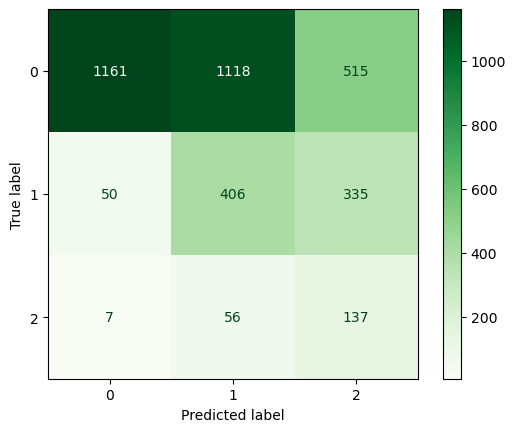

In [240]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [241]:
class_twos = confusion_matrix(y_test, preds)[2]
class_ones = confusion_matrix(y_test, preds)[1]
(cw_values[1]*(class_ones[1]/sum(class_ones))+cw_values[2]*(class_twos[2]/sum(class_twos)))/sum(cw_values[1:]) 
#oh boy.... I just did the 8k one by hand and that was .52ish.... yeah, this is not getting tuned for some reason...

0.6277581120943954

In [153]:
# trial_model.named_steps['lr'].coef_[0]

In [154]:
# trial_model.named_steps['lr'].coef_[2]

In [143]:
# len(trial_model.named_steps['lr'].coef_[2]) == len(trial_model.named_steps['tvec'].get_feature_names_out())

In [155]:
# trial_model.named_steps['tvec'].get_feature_names_out()

In [149]:
confusion_matrix(y_test, preds)

array([[3666, 2995, 1091],
       [ 190, 1236,  768],
       [  15,  251,  288]], dtype=int64)

In [150]:
three = confusion_matrix(y_test, preds)[2]
print((three[2]+three[1]*.5)/sum(three), (three[2]+three[1])/sum(three))
two = confusion_matrix(y_test, preds)[1]
print((two[2]*.5+two[1])/sum(two), (two[2]+two[1])/sum(two))
one = confusion_matrix(y_test, preds)[0]
print((one[0])/sum(one), (one[0]+one[1]*.5)/sum(one))

0.7463898916967509 0.9729241877256317
0.7383773928896992 0.9134001823154057
0.4729102167182663 0.6660861713106295


In [ ]:
#Hmm, I'm honstly pretty pleased with those... Ie obviously, the higher the better. However, we have a lot of issues:
#1 is that often neutral or defensive language is unclear/smudges between the more extreme categories.
#2 Incitement aside, speach is not a crime. So, a one time offense woudln't likely call for confrontation. However,
#depending upon the severity[ie really really bad....] AND most importantly frequently...

#Let's examine a bit more. Maybe later we'll work on graphs... However, I think we'll keep this base approach.
#Ie weights seem to be the way to go and just make sure to check like we've been ding that we don't keep on adding more features
#and lose the 2 accuracy.

#I'll make a graph later, but for now let's look at the relative probabilities. Ie the plan is to go with whatever model,
#then have a variable of how many messages were sent like this? Ie let us confirm a few things:
#1 Anyhing misclassified is NOT 'decently/significantly' misclassifid.
    #or just hard things like a positive/defensive post that is vulgar...
#2 That anything classified correctly is also 'decently/significantly' such.

In [27]:
hyper_pred_comparer

,cleaned_text,actual,pred,p_0,p_1,p_2
6655,like right gun are suddenli bad when brown peo...,0,0,0.690934,0.273799,0.035268
4452,you forgot about kill of the non believ,1,1,0.404492,0.512790,0.082718
8543,but will not be abl to yeah and they won t get...,0,0,0.890687,0.103951,0.005361
28928,jacti0nj2 sheisyoana u gon fall back and lose ...,0,1,0.255760,0.645330,0.098910
22644,women with masculin spirit are trash,1,0,0.737607,0.254461,0.007932
...,...,...,...,...,...,...
21363,pussi nigga make me sick bitch you make me sick,0,2,0.062837,0.380289,0.556874
9744,yea anybodi who talk about grab pussi or galva...,0,1,0.037149,0.641160,0.321691
38623,i love it women turn to rule,0,0,0.716081,0.280192,0.003728
29958,badh badh baba ertugru66904008 lndianpresid ja...,1,2,0.288596,0.301773,0.409631


## A second wind - continuing with modeling

We'll keep the current data size, train test split, and weights. Now that we finally have a proper metric we're tuning for
we got this.

Note that I played around quite a bit with test size and noticed such great changes as it changed. Ie we were hovering
at around .52 'originally' when test size was 10.5k; .63 with the current 3845; a shocking .34ish with 2735. So, this definitely would seem to be a hyperparameer to tune, being based upon the relative resample distribution, however I am satisfied with the current results. As, accordingly to everybody - this is quite a difficult issue to do. And, in all honesty, a model'sperformance isn't so critical when it's going to have multiple messages to compare each other with AND finally have a human visually inspect the messages...
    Reminder that the above custom_recall accuracies were based upon Tiffany with Logreg.

I think I had another proclaimation but whatever. Let us continue and finally build the models. Oh, perhaps it was the acceptance that likely we will end up using all the features. Perhaps that'll change with forests and the like, but I suspect that trend will continue by cvec x logreg at least.

In [244]:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False))
    ,('lr', LogisticRegression(max_iter=2500, multi_class='multinomial', class_weight=current_weights))
])

pipe_params = {'cvec__min_df' : [.00]
               ,'cvec__max_df' : [.95]
               ,'cvec__ngram_range' : [(1, 1),(1,2),(1,3)]
               ,'cvec__max_features' : [2000, 4000, 8000, None]
               ,'cvec__stop_words' : [None, 'english']
               }
scorer = make_scorer(custom_recall, weight_list=cw_values[1:]) #Note the 1: as we're now ignoring 0 for the scoring
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5
                  ,scoring=scorer
                 )

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

0.9976666666666666 0.6097914349604127
0.7034166666666667
{'cvec__max_df': 0.95, 'cvec__max_features': None, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': None}


0.998 0.6459709379128138


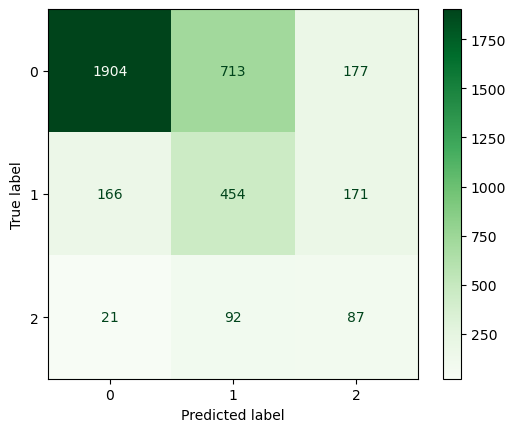

In [245]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [246]:
class_twos = confusion_matrix(y_test, preds)[2]
class_ones = confusion_matrix(y_test, preds)[1]
(cw_values[1]*(class_ones[1]/sum(class_ones))+cw_values[2]*(class_twos[2]/sum(class_twos)))/sum(cw_values[1:])

#Not up to the challenge, but still 'decent'. Note the '1,3'

0.4813190054782975

For the pevious cvec x logreg, as well as the many to com, they in short came disapointingly short of accurately predicting the matters. Perhaps I need to play with more hyperparameters though before I abandon thm.

However,please bear in mind - unlike logreg the following don't have a class_weight parameter. So, as we noticed above, how much of a part that plays IN ADDITION to the theortical encouragement of our pipe to go for the customer. 

In [256]:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('mnb', MultinomialNB())
])
pipe_params = {'cvec__min_df' : [.0]
               ,'cvec__max_df' : [.95]
               ,'cvec__ngram_range' : [(1,3)]
               ,'cvec__max_features' : [14850, 14875, 14900]
               ,'cvec__stop_words' : ['english']
               ,'mnb__alpha': [1.0]
              }
scorer = make_scorer(custom_recall, weight_list=cw_values[1:]) #Note the 1: as we're now ignoring 0 for the scoring
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5
                  ,scoring=scorer
                 )

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

0.8178333333333332 0.6782481333035302
0.6955833333333332
{'cvec__max_df': 0.95, 'cvec__max_features': 14850, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': 'english', 'mnb__alpha': 1.0}


0.7615833333333333 0.6874504623513871
<bound method Pipeline.get_params of Pipeline(steps=[('cvec',
                 CountVectorizer(lowercase=False, max_df=0.95,
                                 max_features=14850, min_df=0.0,
                                 ngram_range=(1, 3), stop_words='english')),
                ('to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x0000024B6B2BCFE0>)),
                ('mnb', MultinomialNB())])>


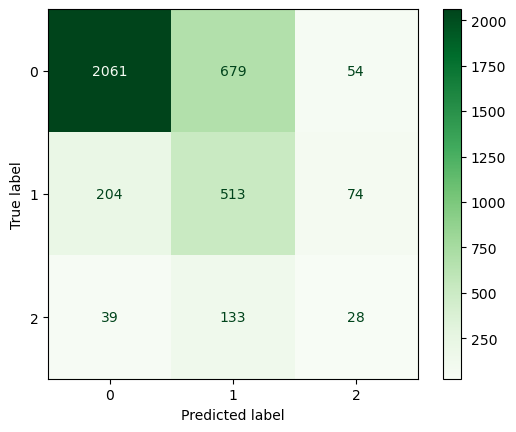

In [259]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))
print(trial_model.get_params)

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [258]:
class_twos = confusion_matrix(y_test, preds)[2]
class_ones = confusion_matrix(y_test, preds)[1]
(cw_values[1]*(class_ones[1]/sum(class_ones))+cw_values[2]*(class_twos[2]/sum(class_twos)))/sum(cw_values[1:])
#Hmm, yeah that's not good... decent on 1s though. Notice i the documentations that the 

0.3095153813737885

In [279]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('mnb', MultinomialNB())
])
pipe_params = {'tvec__min_df' : [.0]
               ,'tvec__max_df' : [.95]
               ,'tvec__ngram_range' : [(1,3), (2,3),(1,4)]
               ,'tvec__max_features' : [18000, 18050, 17950]
               ,'tvec__stop_words' : ['english']
               ,'mnb__alpha': [.98]
              }
scorer = make_scorer(custom_recall, weight_list=cw_values[1:]) #Note the 1: as we're now ignoring 0 for the scoring
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5
                  ,scoring=scorer
                 )

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

0.8269166666666667 0.6770744063267232
0.6980000000000001
{'mnb__alpha': 0.98, 'tvec__max_df': 0.95, 'tvec__max_features': 18050, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 4), 'tvec__stop_words': 'english'}


0.7813333333333333 0.7064729194187582
<bound method Pipeline.get_params of Pipeline(steps=[('tvec',
                 TfidfVectorizer(lowercase=False, max_df=0.95,
                                 max_features=18050, min_df=0.0,
                                 ngram_range=(1, 4), stop_words='english')),
                ('to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x0000024B13F77880>)),
                ('mnb', MultinomialNB(alpha=0.98))])>


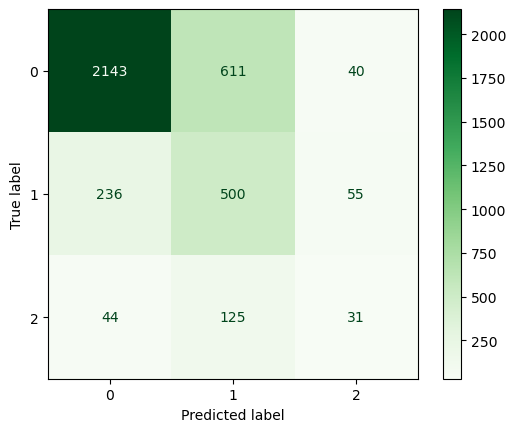

In [280]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))
print(trial_model.get_params)

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [281]:
class_twos = confusion_matrix(y_test, preds)[2]
class_ones = confusion_matrix(y_test, preds)[1]
(cw_values[1]*(class_ones[1]/sum(class_ones))+cw_values[2]*(class_twos[2]/sum(class_twos)))/sum(cw_values[1:])

0.3140370838600927

In [287]:
#ote, this one ran pretty quickly.
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('gnb', GaussianNB())
])
pipe_params = {'cvec__min_df' : [.05]
               ,'cvec__max_df' : [.95]
               ,'cvec__ngram_range' : [(1,2)]
               ,'cvec__max_features' : [2000, 1975, 2025]
               ,'cvec__stop_words' : [None]
              }
scorer = make_scorer(custom_recall, weight_list=cw_values[1:]) #Note the 1: as we're now ignoring 0 for the scoring
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5
                  ,scoring=scorer
                 )

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

0.5446666666666666 0.5435011995182017
0.5385833333333334
{'cvec__max_df': 0.95, 'cvec__max_features': 2000, 'cvec__min_df': 0.05, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None}


0.47541666666666665 0.5128137384412154
<bound method Pipeline.get_params of Pipeline(steps=[('cvec',
                 CountVectorizer(lowercase=False, max_df=0.95,
                                 max_features=2000, min_df=0.05,
                                 ngram_range=(1, 2))),
                ('to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x0000024B1C2CA3E0>)),
                ('gnb', GaussianNB())])>


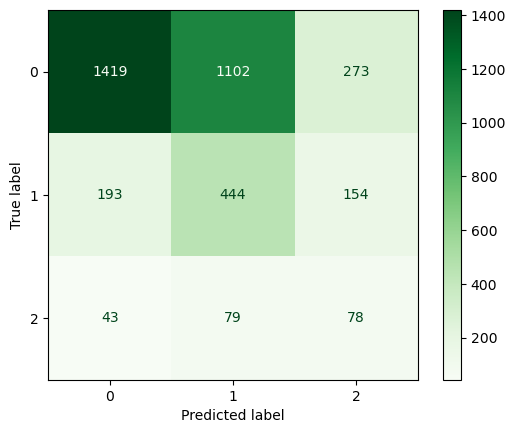

In [288]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))
print(trial_model.get_params)

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [289]:
class_twos = confusion_matrix(y_test, preds)[2]
class_ones = confusion_matrix(y_test, preds)[1]
(cw_values[1]*(class_ones[1]/sum(class_ones))+cw_values[2]*(class_twos[2]/sum(class_twos)))/sum(cw_values[1:])

0.4471049304677623

In [298]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('gnb', GaussianNB())
])
pipe_params = {'tvec__min_df' : [.0]
               ,'tvec__max_df' : [.95]
               ,'tvec__ngram_range' : [(1,2)]
               ,'tvec__max_features' : [14825, 14925, 14875]
               ,'tvec__stop_words' : [None]
              }
scorer = make_scorer(custom_recall, weight_list=cw_values[1:]) #Note the 1: as we're now ignoring 0 for the scoring
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5
                  ,scoring=scorer
                 )

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

0.9605000000000001 0.5833985655252465
0.68225
{'tvec__max_df': 0.95, 'tvec__max_features': 14875, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}


0.9036666666666666 0.6050198150594451
<bound method Pipeline.get_params of Pipeline(steps=[('tvec',
                 TfidfVectorizer(lowercase=False, max_df=0.95,
                                 max_features=14875, min_df=0.0,
                                 ngram_range=(1, 2))),
                ('to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x0000024B13F76FC0>)),
                ('gnb', GaussianNB())])>


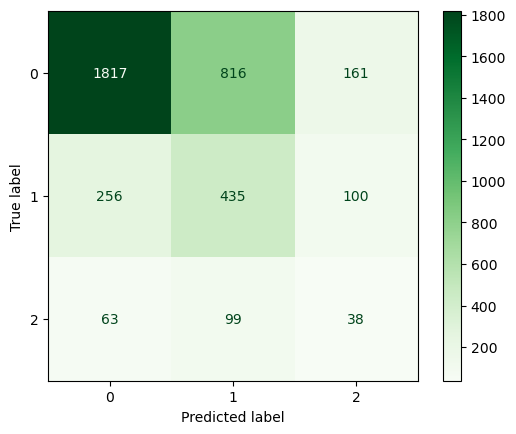

In [299]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))
print(trial_model.get_params)

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [300]:
class_twos = confusion_matrix(y_test, preds)[2]
class_ones = confusion_matrix(y_test, preds)[1]
(cw_values[1]*(class_ones[1]/sum(class_ones))+cw_values[2]*(class_twos[2]/sum(class_twos)))/sum(cw_values[1:])

0.30997892962494733

In [ ]:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('conb', ComplementNB())
])
pipe_params = {'cvec__min_df' : [.0]
               ,'cvec__max_df' : [.95]
               ,'cvec__ngram_range' : [(1, 1)]
               ,'cvec__max_features' : [4400, 4350, 4450]
               ,'cvec__stop_words' : [None]
               ,'conb__alpha': [1.0]
              }
scorer = make_scorer(custom_recall, weight_list=cw_values[1:]) #Note the 1: as we're now ignoring 0 for the scoring
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5
                  ,scoring=scorer
                 )

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))
print(trial_model.get_params)

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [ ]:
class_twos = confusion_matrix(y_test, preds)[2]
class_ones = confusion_matrix(y_test, preds)[1]
(cw_values[1]*(class_ones[1]/sum(class_ones))+cw_values[2]*(class_twos[2]/sum(class_twos)))/sum(cw_values[1:])

In [ ]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('cong', ComplementNB())
])
pipe_params = {'tvec__min_df' : [.0]
               ,'tvec__max_df' : [.95]
               ,'tvec__ngram_range' : [(1,1)]
               ,'tvec__max_features' : [4500, 4400, 4600]
               ,'tvec__stop_words' : ['english', None]
               ,'conb__alpha': [1.0]
              }
scorer = make_scorer(custom_recall, weight_list=cw_values[1:]) #Note the 1: as we're now ignoring 0 for the scoring
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5
                  ,scoring=scorer
                 )

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))
print(trial_model.get_params)

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [ ]:
class_twos = confusion_matrix(y_test, preds)[2]
class_ones = confusion_matrix(y_test, preds)[1]
(cw_values[1]*(class_ones[1]/sum(class_ones))+cw_values[2]*(class_twos[2]/sum(class_twos)))/sum(cw_values[1:])

In [ ]:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('svc', SVC())
])
pipe_params = {'cvec__min_df' : [.0]
               ,'cvec__max_df' : [1.0]
               ,'cvec__ngram_range' : [(1,1), (1,2)]
               ,'cvec__max_features' : [2000, 4000]
               ,'cvec__stop_words' : ['english', None]
               ,'svc__kernel': ['linear']
               ,'svc__C': [.95, .1]
              }
scorer = make_scorer(custom_recall, weight_list=cw_values[1:]) #Note the 1: as we're now ignoring 0 for the scoring
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5
                  ,scoring=scorer
                 )

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))
print(trial_model.get_params)

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [ ]:
class_twos = confusion_matrix(y_test, preds)[2]
class_ones = confusion_matrix(y_test, preds)[1]
(cw_values[1]*(class_ones[1]/sum(class_ones))+cw_values[2]*(class_twos[2]/sum(class_twos)))/sum(cw_values[1:])

In [ ]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('svc', SVC())
])
pipe_params = {'tvec__min_df' : [.0]
               ,'tvec__max_df' : [1.0]
               ,'tvec__ngram_range' : [(1,2), (1,1)]
               ,'tvec__max_features' : [2000, 4000]
               ,'tvec__stop_words' : ['english']
               ,'svc__kernel': ['linear']
               ,'svc__C': [.95]
              }
scorer = make_scorer(custom_recall, weight_list=cw_values[1:]) #Note the 1: as we're now ignoring 0 for the scoring
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5
                  ,scoring=scorer
                 )

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))
print(trial_model.get_params)

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [ ]:
class_twos = confusion_matrix(y_test, preds)[2]
class_ones = confusion_matrix(y_test, preds)[1]
(cw_values[1]*(class_ones[1]/sum(class_ones))+cw_values[2]*(class_twos[2]/sum(class_twos)))/sum(cw_values[1:])

In [ ]:
#Future ground for forests

In [ ]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))
print(trial_model.get_params)

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [ ]:
class_twos = confusion_matrix(y_test, preds)[2]
class_ones = confusion_matrix(y_test, preds)[1]
(cw_values[1]*(class_ones[1]/sum(class_ones))+cw_values[2]*(class_twos[2]/sum(class_twos)))/sum(cw_values[1:])

In [ ]:
#Future ground for forests

In [ ]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))
print(trial_model.get_params)

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [ ]:
class_twos = confusion_matrix(y_test, preds)[2]
class_ones = confusion_matrix(y_test, preds)[1]
(cw_values[1]*(class_ones[1]/sum(class_ones))+cw_values[2]*(class_twos[2]/sum(class_twos)))/sum(cw_values[1:])